In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# plt = matplotlib.pyplot
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm

import pickle
import sys
sys.path.append('..')
from nsgp_vi import nsgpVI
#from move_model_non_white import GPMove


tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels



# from utils.mala_sampler import AdaptiveMALA

tf.__version__

'2.6.2'

In [2]:
domain_size = 10.

In [3]:

# Set up the inducing grid
grid_size = 20
num_inducing_points_= grid_size*grid_size
x = np.linspace(0, domain_size, grid_size,endpoint=False)[...,np.newaxis] 
y = np.linspace(0, domain_size, grid_size,endpoint=False)[...,np.newaxis]

xx, yy = np.meshgrid(x, y, sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()])


x_grid = x_grid.T
print(x_grid.shape)

x_grid_r = x_grid.copy()
np.random.shuffle(x_grid_r)



(400, 2)


In [4]:
#Load the data
df = pd.read_csv('../data/synthetic_data/positions_b2.csv')
T = df['Time'].values[:,None]
ID = df['ID'].values


num_training_points_ = T.shape[0]

X_x = df['Latitude'].values
X_y = df['Longitude'].values
X = np.zeros((len(X_x),2))
X[:,0] = X_x
X[:,1] = X_y

print(np.shape(X))
print(np.shape(T))
sigma = np.array(df['Sigma'].values).reshape(len(X_x),1)
beta = np.array(df['Beta'].values).reshape(len(X_x),1)

(100000, 2)
(100000, 1)


In [5]:
df

,Unnamed: 0,Time,Latitude,Longitude,Beta,Sigma,ID
0,0,0.0,9.040679,8.333747,0.000000,0.000000,0
1,1,0.5,9.109495,8.376131,0.909955,0.299646,0
2,2,1.0,9.246967,8.389201,0.892105,0.303047,0
3,3,1.5,9.373938,8.478155,0.869370,0.307483,0
4,4,2.0,9.420961,8.554138,0.860324,0.309281,0
...,...,...,...,...,...,...,...
99995,99995,49997.5,-12.135659,-12.149165,0.970707,0.288563,199
99996,99996,49998.0,-12.196332,-12.231796,0.971969,0.288341,199
99997,99997,49998.5,-12.247690,-12.302090,0.972725,0.288208,199
99998,99998,49999.0,-12.361193,-12.320598,0.973400,0.288089,199


In [6]:
# create the dataset

BATCH_SIZE=8
SEG_LENGTH=500

allT = []
allX = []
for i in np.unique(df['ID'].values):
    allT.append(df['Time'][df['ID'].values == i].values[...,None])
    
    X_x = df['Latitude'][df['ID'].values == i].values
    X_y = df['Longitude'][df['ID'].values == i].values
    X = np.zeros((len(X_x),2))
    X[:,0] = X_x
    X[:,1] = X_y
    allX.append(X)

class segment_generator:
    def __iter__(self):
        
        # loop over individuals
        self.i = 0
        self.max_i = len(allT)
        
        # loop over segments
        self.j = 0
        self.max_j = num_training_points_//(self.max_i*SEG_LENGTH)
        
        
        
        return self

    def __next__(self):
        
        if self.i == self.max_i:
            self.i = 0
            self.j +=1
            if self.j==self.max_j:
                raise StopIteration
            
        T = allT[self.i]
        X = allX[self.i] 

        

        TT = T[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
        XX = X[self.j*SEG_LENGTH:(self.j+1)*SEG_LENGTH]
    
        self.i += 1

        return TT,XX,XX

        
dataset = tf.data.Dataset.from_generator(segment_generator, (tf.float64,tf.float64,tf.float64),output_shapes=(tf.TensorShape([None,1]),tf.TensorShape([None,2]),tf.TensorShape([None,2]))) 
#dataset = dataset.map(lambda dd: (dd[0],dd[1]))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE)
d_size = T.shape[0]//SEG_LENGTH//(BATCH_SIZE)

2022-01-11 20:30:22.090205: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 20:30:23.289272: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15391 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:3b:00.0, compute capability: 6.0


In [7]:
## set up the kernels and model

kernel_len_a = tfp.util.TransformedVariable(1.,tfb.Softplus(),dtype=tf.float64, name='k_len_a',trainable=True)
kernel_len_l = tfp.util.TransformedVariable(1.,tfb.Chain([tfb.Shift(np.float64(0.5)),tfb.Softplus()]),dtype=tf.float64, name='k_len_l',trainable=True)

# amplitude kernel parameters, lower levels
kernel_amp_a = tfp.util.TransformedVariable(1.,tfb.Softplus(), dtype=tf.float64, name='k_amp_a',trainable=True)
kernel_amp_l = tfp.util.TransformedVariable(1.,tfb.Chain([tfb.Shift(np.float64(0.5)),tfb.Softplus()]), dtype=tf.float64, name='k_amp_l',trainable=True)

    #kernels on the second layer
kernel_len = tfk.ExpSinSquared(kernel_len_a,kernel_len_l,period=domain_size)
kernel_amp = tfk.ExpSinSquared(kernel_amp_a,kernel_amp_l,period=domain_size)

vgp = nsgpVI(kernel_len,kernel_amp,n_inducing_points=num_inducing_points_,inducing_index_points=x_grid_r,dataset=dataset,num_training_points=num_training_points_, num_sequential_samples=5,num_parallel_samples=10,init_observation_noise_variance=0.005**2)  

In [8]:
loss = vgp.optimize(BATCH_SIZE, SEG_LENGTH, NUM_EPOCHS=200)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2022-01-11 20:30:24.185996: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_26"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 2
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 2
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_DOUBLE
      typ

Instructions for updating:
Do not call `graph_parents`.


2022-01-11 20:30:26.558358: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-01-11 20:30:31.980724: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x561202a26650
Loss -8967.850471, klen 1.456264: 100%|██████████| 200/200 [1:49:06<00:00, 32.73s/it]


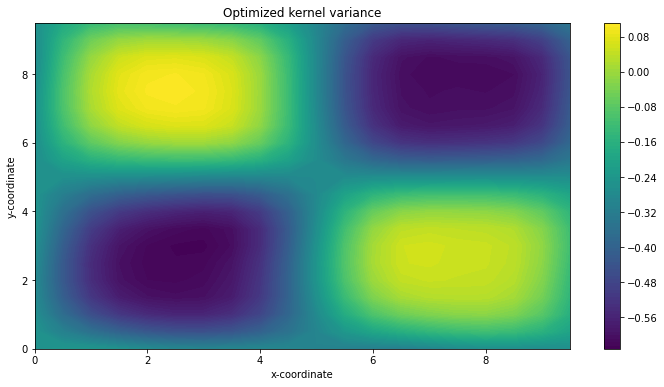

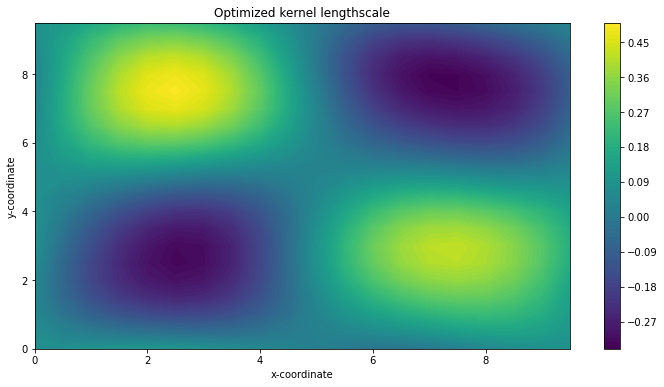

In [9]:

mean_list, var_list = vgp.get_marginal(x_grid)

len_grid = mean_list[0].numpy().reshape(grid_size,grid_size)
var_grid = mean_list[1].numpy().reshape(grid_size,grid_size)
plt.contourf(xx,yy, var_grid,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel variance')
plt.show()
plt.contourf(xx,yy,len_grid,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel lengthscale')
plt.show()

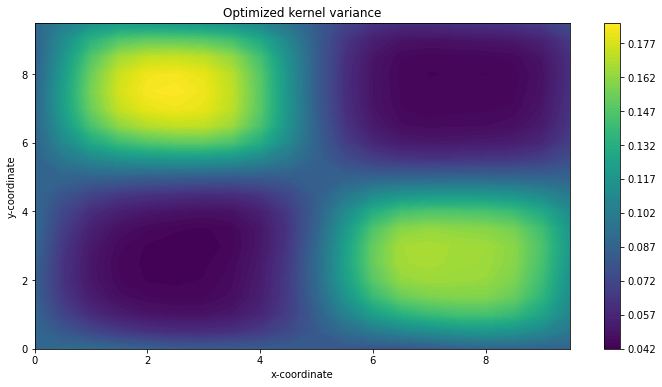

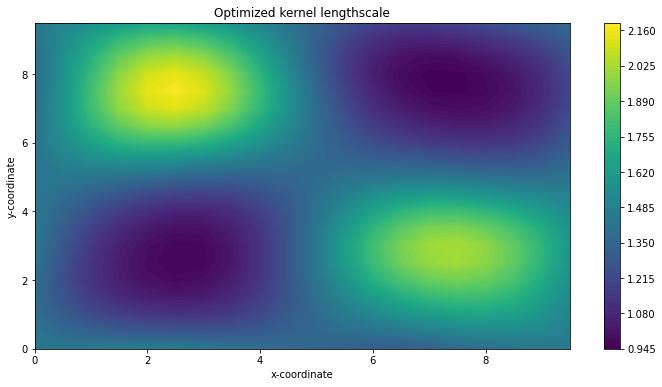

In [15]:

len_samples, var_samples = vgp.get_samples(x_grid, S=1000)

#len_grid = np.mean(len_samples.numpy(),axis=0).reshape(grid_size,grid_size)
len_grid = np.mean(len_samples.numpy().reshape(-1,grid_size,grid_size),axis=0)
var_grid = np.mean(var_samples.numpy().reshape(-1,grid_size,grid_size),axis=0)

# var_grid = mean_list[1].numpy().reshape(grid_size,grid_size)
plt.contourf(xx,yy, var_grid**2,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel variance')
plt.show()
plt.contourf(xx,yy,len_grid,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel lengthscale')
plt.show()

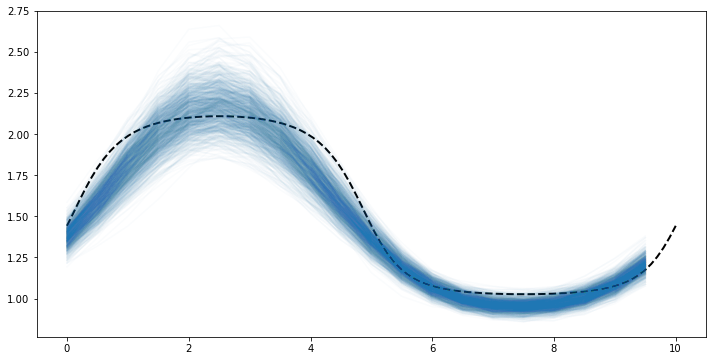

In [18]:
ls = len_samples.numpy().reshape(-1,grid_size,grid_size)
plt.plot(x_HMC,true_len,color='black',lw= 2,linestyle='dashed')
for i in range(1000):
    plt.plot(xx[0],ls[i,15,:],c='C0',alpha=0.02)
plt.show()

In [13]:
# vgp.trainable_variables

In [12]:
num_HMC = 100
x_HMC = np.linspace(0, 10, num_HMC)[...,np.newaxis]
y_HMC = 7.5*np.ones(num_HMC)[...,np.newaxis] # might change here
xx_HMC, yy_HMC = np.meshgrid(x_HMC, y_HMC, sparse=False)
x_HMC_grid = np.array([xx_HMC.flatten(), yy_HMC.flatten()])
X_HMC_grid=x_HMC_grid.T[:num_HMC] # take the relevant pairs that do not repeat themselves
np.shape(X_HMC_grid)
l = 10 # lengthscale of the domain 
k = 1 # any k 
f = k/l # k - integer

beta_max = 1.0
beta_range = 0.5

sigma_max = 0.5
sigma_range = -0.25

b = 2

def trunc_sin(v):
    return np.sqrt((1+b**2)/((1+(b**2)*(np.sin(v))**2)))*np.sin(v)

def beta_value(x,y):
    return beta_max*np.logaddexp(0,beta_range*trunc_sin(2*np.pi*f*x) * trunc_sin(2*np.pi*f*y))
    
def sigma_value(x,y):
    return sigma_max*np.logaddexp(0,sigma_range*trunc_sin(2*np.pi*f*x) * trunc_sin(2*np.pi*f*y))

# get the true values at the slices
Beta_slice = beta_max*np.logaddexp(0,beta_range*trunc_sin(2*np.pi*f*x_HMC) * trunc_sin(2*np.pi*f*y_HMC))
Sigma_slice = sigma_max*np.logaddexp(0,sigma_range*trunc_sin(2*np.pi*f*x_HMC) * trunc_sin(2*np.pi*f*y_HMC))
true_var = (Sigma_slice**2)/(2*Beta_slice)
true_len = (1/Beta_slice)

In [15]:
true_len

(100, 1)

In [16]:
vgp.kernel_amp.length_scale

<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=1.2542868871860748>

In [8]:
for d in dataset:
    #print(d)
    
    observation_times = d[0]
    observations = d[1]
    latent_locations = d[1]

    break
    
len_vals, amp_vals = vgp.get_samples(latent_locations,S=vgp.num_parallel_samples)

Instructions for updating:
Do not call `graph_parents`.


2022-01-11 11:22:51.558557: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-11 11:22:51.711996: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x559390ab7b00


In [10]:
vgp.variational_loss(observations,observation_times)

<tf.Tensor: shape=(), dtype=float64, numpy=165515.1659692527>

In [75]:
lengthscales = len_vals
stddev = amp_vals
X = observation_times
T = observation_times


In [73]:
Xs = tf.reduce_sum(input_tensor=tf.square(X), axis=-1, keepdims=True)#(1000,1)
Ls = tf.square(lengthscales)#(1,1000,1)

dist = -2 * tf.matmul(X, X, transpose_b=True)
dist += Xs + tf.linalg.matrix_transpose(Xs)
Lscale = Ls + tf.linalg.matrix_transpose(Ls)
dist = tf.divide(2*dist,Lscale)
dist = tf.sqrt(tf.maximum(dist, 1e-40))
prefactL = 2 * tf.matmul(lengthscales, lengthscales, transpose_b=True)
prefactV = tf.matmul(stddev, stddev, transpose_b=True)

K =  tf.multiply(prefactV,tf.multiply( tf.sqrt(tf.maximum(tf.divide(prefactL,Lscale), 1e-40)),tf.exp(-dist)))

In [82]:
K.shape

TensorShape([10, 8, 499, 499])

In [81]:
sigma_ = 0.5*(stddev[...,:-1,0,None] + stddev[...,1:,0,None])
len_ = 0.5*(lengthscales[...,:-1,0,None] + lengthscales[...,1:,0,None])

Ls = tf.square(len_)

L = tf.math.sqrt(0.5*(Ls + tf.linalg.matrix_transpose(Ls)))

prefactL = tf.math.sqrt(tf.matmul(len_, len_, transpose_b=True))
prefactV = tf.matmul(sigma_, sigma_,transpose_b=True)

zeta = tf.math.multiply(prefactV,tf.math.divide(prefactL,L))


tpq1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,:-1]) - T[:,1:]),L))
tp1q1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,1:]) - T[:,1:]),L))
tpq = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,:-1]) - T[:,:-1]),L))
tp1q = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:,1:]) - T[:,:-1]),L))


Epq_grid = tpq1-tp1q1-tpq+tp1q
Epq_grid = (L**2)*Epq_grid

Epq_grid = tf.linalg.set_diag(Epq_grid,(tf.linalg.diag_part(Epq_grid)) + 2.0*len_[...,0]*((T[:,1:,0])-(T[:,:-1,0])))
Epq_grid = zeta*Epq_grid


K = tf.math.cumsum(tf.math.cumsum(Epq_grid,axis=-2,exclusive=False),axis=-1,exclusive=False)

In [86]:
observations.shape

TensorShape([8, 500, 2])

<tf.Tensor: shape=(8, 500, 2), dtype=float64, numpy=
array([[[  0.        ,   0.        ],
        [ -0.03142426,  -0.05071352],
        [  0.12013337,  -0.05300698],
        ...,
        [ -1.69022788,  -1.74287454],
        [ -1.74535719,  -1.71380515],
        [ -1.69834196,  -1.71075175]],

       [[  0.        ,   0.        ],
        [ -0.16795142,   0.10828972],
        [ -0.21388875,   0.21345168],
        ...,
        [ -9.6213078 ,  -2.84411757],
        [ -9.50609579,  -2.87846684],
        [ -9.44969209,  -3.01506841]],

       [[  0.        ,   0.        ],
        [ -0.18425015,   0.0556896 ],
        [ -0.39785799,   0.02538152],
        ...,
        [ -2.81327987,   1.71267008],
        [ -2.86497867,   1.70201924],
        [ -2.98235464,   1.67078452]],

       ...,

       [[  0.        ,   0.        ],
        [ -0.0438895 ,  -0.20790798],
        [ -0.15252213,  -0.3545871 ],
        ...,
        [ -0.95623385,   1.73374565],
        [ -1.09078904,   1.8817259 ],
  

In [96]:

centered_observations = observations[...,1:,:]-observations[...,0,None,:] #centered observations

logpdf_K_x = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(K)).log_prob((centered_observations[...,0])),axis=0))
logpdf_K_y = tf.reduce_sum(tf.reduce_mean(tfd.MultivariateNormalTriL(scale_tril = tf.linalg.cholesky(K)).log_prob((centered_observations[...,1])),axis=0))
        #logpdf_K_x = tfd.MultivariateNormalTriL(scale_tril = L).log_prob(X[1:,0]-X[0,0])
        #logpdf_K_y = tfd.MultivariateNormalTriL(scale_tril = L).log_prob(X[1:,1]-X[0,1])

<tf.Tensor: shape=(), dtype=float64, numpy=-38676.46356510211>

In [ ]:
def non_stat_matern12(self, X, lengthscales, stddev):
        ''' Non-stationary Matern 12 kernel'''
        
        Xs = tf.reduce_sum(input_tensor=tf.square(X), axis=-1, keepdims=True)#(1000,1)
        Ls = tf.square(lengthscales)#(1,1000,1)
        
        dist = -2 * tf.matmul(X, X, transpose_b=True)
        dist += Xs + tf.linalg.matrix_transpose(Xs)
        Lscale = Ls + tf.linalg.matrix_transpose(Ls)
        dist = tf.divide(2*dist,Lscale)
        dist = tf.sqrt(tf.maximum(dist, 1e-40))
        prefactL = 2 * tf.matmul(lengthscales, lengthscales, transpose_b=True)
        prefactV = tf.matmul(stddev, stddev, transpose_b=True)

        return tf.multiply(prefactV,tf.multiply( tf.sqrt(tf.maximum(tf.divide(prefactL,Lscale), 1e-40)),tf.exp(-dist)))


    def non_stat_vel(self,T,lengthscales, stddev):
        
        """Non-stationary integrated Matern12 kernel"""

        sigma_ = 0.5*(stddev[...,:-1,0,None] + stddev[...,1:,0,None])
        len_ = 0.5*(lengthscales[...,:-1,0,None] + lengthscales[...,1:,0,None])

        Ls = tf.square(len_)

        L = tf.math.sqrt(0.5*(Ls + tf.linalg.matrix_transpose(Ls)))

        prefactL = tf.math.sqrt(tf.matmul(len_, len_, transpose_b=True))
        prefactV = tf.matmul(sigma_, sigma_,transpose_b=True)

        zeta = tf.math.multiply(prefactV,tf.math.divide(prefactL,L))
    

        tpq1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:-1]) - T[1:]),L))
        tp1q1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[1:]) - T[1:]),L))
        tpq = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:-1]) - T[:-1]),L))
        tp1q = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[1:]) - T[:-1]),L))


        Epq_grid = tpq1-tp1q1-tpq+tp1q
        Epq_grid = (L**2)*Epq_grid
                
        Epq_grid = tf.linalg.set_diag(Epq_grid,(tf.linalg.diag_part(Epq_grid)) + 2.0*tf.squeeze(len_)[:]*(tf.squeeze(T[1:])-tf.squeeze(T[:-1])))
        Epq_grid = zeta*Epq_grid
        
        
        K = tf.math.cumsum(tf.math.cumsum(Epq_grid,axis=-2,exclusive=False),axis=-1,exclusive=False)
        
        return K
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2022-01-11 11:23:49.146843: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:695] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_24"
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 2
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
. Consider either turning off auto-sharding or switching the auto_shard_policy to 

KeyboardInterrupt: 

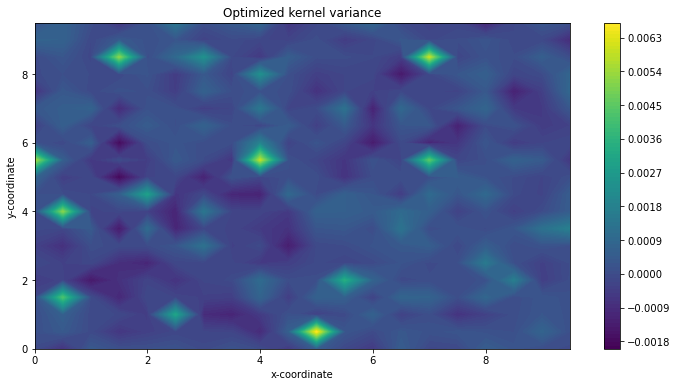

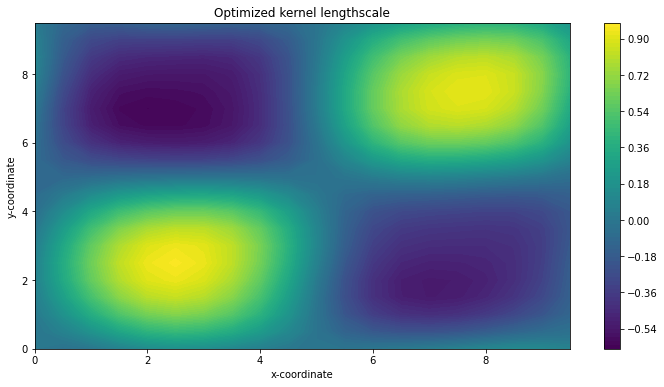

In [31]:
#len_grid = m.predict_length(Xnew=x_grid).numpy().reshape(num,num)
#var_grid = m.predict_var(Xnew=x_grid).numpy().reshape(num,num)

vgp.get_marginal(x_grid)

len_grid = mean_list[0].numpy().reshape(grid_size,grid_size)
var_grid = mean_list[1].numpy().reshape(grid_size,grid_size)
plt.contourf(xx,yy, var_grid,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel variance')
plt.show()
plt.contourf(xx,yy,len_grid,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel lengthscale')
plt.show()
# -26860
# print(m.V_var_mean.numpy(), m.k_var_a.numpy(),m.k_var_l.numpy(),m.V_len_mean.numpy(),np.exp(m.k_len_a.numpy()),m.k_len_l.numpy())
    
# #qq = loadp['V_len'].reshape((20,20))
# plt.plot(len_grid[15])
# #plt.plot(np.arange(0,20,0.2),(sigma_grid[75]**0)/(1*beta_grid[75]))
# plt.show()

In [27]:
Xnew = x_grid

Z_amp = vgp.amp_inducing_index_points 
Z_len = vgp.len_inducing_index_points 

#Z=tf.linalg.LinearOperatorFullMatrix(Z)


kernel_amp = vgp.kernel_amp
kernel_len = vgp.kernel_len

f = vgp.variational_inducing_observations_loc
q_sqrt = vgp.variational_inducing_observations_scale



M = tf.shape(f)[0]
Kmm_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z_amp,Z_amp) + vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)
Kmm_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z_len,Z_len) + vgp.jitter * tf.eye(M//2, dtype=tf.float64),is_positive_definite=True,is_self_adjoint=True)

Kmm = tf.linalg.LinearOperatorBlockDiag([Kmm_len,Kmm_amp])


Kmn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Z_amp, Xnew),is_positive_definite=True,is_self_adjoint=True)
Kmn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Z_len, Xnew),is_positive_definite=True,is_self_adjoint=True)

Kmn = tf.linalg.LinearOperatorBlockDiag([Kmn_len,Kmn_amp])

#Knn = kernel_amp.matrix(Xnew,Xnew)
Knn_amp = tf.linalg.LinearOperatorFullMatrix(kernel_amp.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
Knn_len = tf.linalg.LinearOperatorFullMatrix(kernel_len.matrix(Xnew, Xnew),is_positive_definite=True,is_self_adjoint=True)
Knn = tf.linalg.LinearOperatorBlockDiag([Knn_len,Knn_amp])

mean,var = vgp.marginal(Kmn.to_dense(),Kmm.to_dense(),Knn.to_dense(),f,q_sqrt)
        
mean_list = tf.split(mean,2,axis=0)
#         var_list = tf.split(var,NUM_LATENT,axis=0)

#         return mean_list, var_list

InvalidArgumentError: Number of ways to split should evenly divide the split dimension, but got split_dim 1 (size = 1) and num_split 2 [Op:Split] name: split

In [ ]:
#tf.math.floormod(allX[0],10.)

In [ ]:
# for d in dataset.take(1):
#     print(d)
#     break

In [17]:


#from move_model2 import GPMove








#m = GPMove(T,x_grid_r,X,ID,BATCH_SIZE=500, domain=10.0, k_len_a=1.0, k_len_l=2.0, k_var_a=1.0, k_var_l=2.0)
#m = GPMove(T,x_grid,X,ID,BATCH_SIZE=500, domain=10.0, k_len_a=5.0, k_len_l=0.25, k_var_a=5, k_var_l=0.25)


#m.dist_optimize(iters=100)


(2, 400)
(100000, 2)
(100000, 1)


In [8]:
kk = tfk.ExpSinSquared()
kk.matrix(x_grid,x_grid)

x_grid.shape

(400, 2)

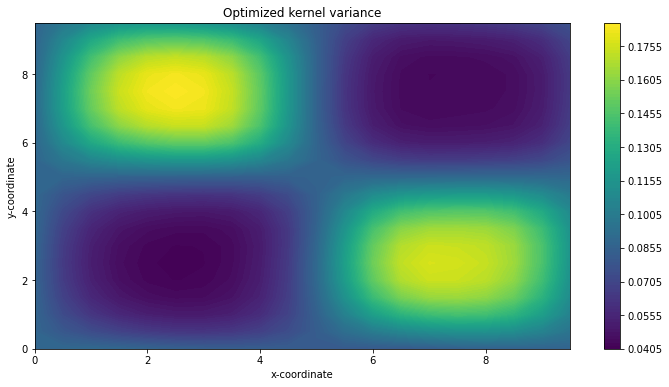

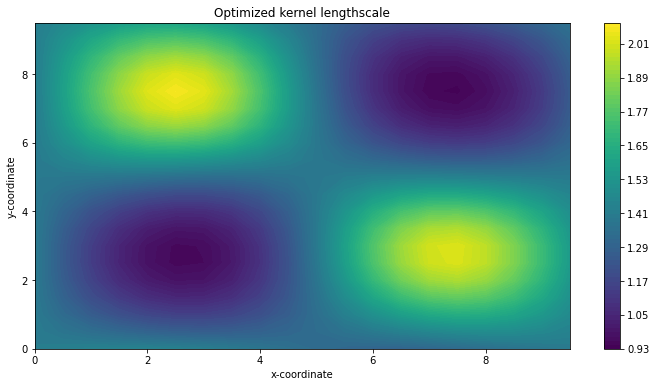

[-0.49616546] [0.45420943] [0.61686808] [0.00087045] [0.89635684] [1.31201997]


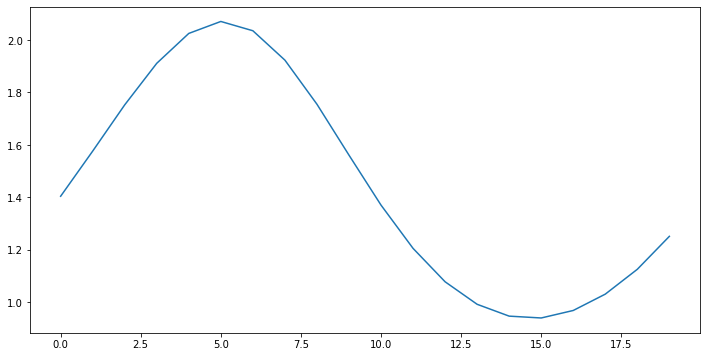

In [13]:
len_grid = m.predict_length(Xnew=x_grid).numpy().reshape(num,num)
var_grid = m.predict_var(Xnew=x_grid).numpy().reshape(num,num)
plt.contourf(xx,yy, var_grid,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel variance')
plt.show()
plt.contourf(xx,yy,len_grid,levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel lengthscale')
plt.show()
-26860
print(m.V_var_mean.numpy(), m.k_var_a.numpy(),m.k_var_l.numpy(),m.V_len_mean.numpy(),np.exp(m.k_len_a.numpy()),m.k_len_l.numpy())
    
#qq = loadp['V_len'].reshape((20,20))
plt.plot(len_grid[15])
#plt.plot(np.arange(0,20,0.2),(sigma_grid[75]**0)/(1*beta_grid[75]))
plt.show()
#[1.23482499] [1.34044841] [0.70756662] [1.60285568]

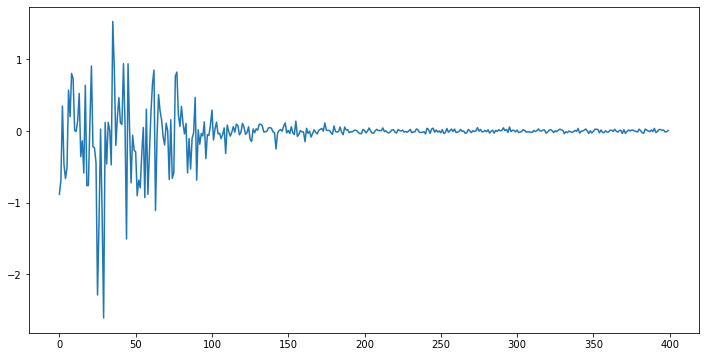

In [5]:
plt.plot(m.V_var.numpy())

In [50]:
kernel_v = tfp.math.psd_kernels.ExponentiatedQuadratic(0.4, tf.math.exp(-100+m.k_var_l))#, m.L)
K_var = kernel_v.matrix(m.X_grid,m.X_grid)
L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
F_var_v = tf.squeeze(tf.expand_dims(m.V_var,-1))
logpdf_K_var =  tfp.distributions.MultivariateNormalTriL(loc=np.float64(0), scale_tril = L_var).log_prob((F_var_v))

logpdf_K_var

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-232.50534112])>

In [11]:
np.exp(m.k_var_a)
#22021724.5608419/8897006.24376634

array([1.03169979])

In [7]:
print(m.V_var.numpy().std())
tf.math.exp(m.k_var_a)

0.3984375358868587


<tf.Tensor: shape=(1,), dtype=float64, numpy=array([1.16990123])>

In [80]:


kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l))#,m.L)
K_len = kernel_l.matrix(m.X_grid,m.X_grid)
L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)

kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l))#,m.L)
K_var = kernel_v.matrix(m.X_grid,m.X_grid)
L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)

#x = tf.linalg.cholesky(true_cov)
identity_matrix =  tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64)
# Note `matrix_triangular_solve` implicitly zeros upper triangular of `x`.
y = tf.linalg.triangular_solve(L_len, identity_matrix)
y = tf.matmul(y, y, adjoint_a=True)
precision_factor_L = tf.linalg.cholesky(y)

y = tf.linalg.triangular_solve(L_var, identity_matrix)
y = tf.matmul(y, y, adjoint_a=True)
precision_factor_V = tf.linalg.cholesky(y)

tfd_e = tfp.experimental.distributions

tfd = tfp.distributions
#precision_factor_L = tf.linalg.cholesky(tf.linalg.inv(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6) + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-3)
#precision_factor_V = tf.linalg.cholesky(tf.linalg.inv(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6) + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-3)

#precision_factor = L_var#tf.linalg.cholesky(precision + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-2)
# momentum_distribution = tfp.experimental.as_composite(
# tfp.distributions.JointDistributionSequential([
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_len),
# ), 
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_var),
# )
    
# ]))


momentum_distribution = tfp.experimental.as_composite(
tfp.distributions.JointDistributionSequential([
    tfd.MultivariateNormalTriL(
    loc=0, scale_tril=precision_factor_L
    
), 
    tfd.MultivariateNormalTriL(
    loc=0    , scale_tril=precision_factor_V
)
    
]))


# moomentum_distribution = tfp.distributions.JointDistributionSequential([
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_len),
# ), 
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_var),
# )
    
# ])

In [89]:


K_len = np.cov(samples[0].numpy().reshape((-1,400)),rowvar=False)
L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)

K_var = np.cov(samples[1].numpy().reshape((-1,400)),rowvar=False)
L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)

#x = tf.linalg.cholesky(true_cov)
identity_matrix =  tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64)
# Note `matrix_triangular_solve` implicitly zeros upper triangular of `x`.
y = tf.linalg.triangular_solve(L_len, identity_matrix)
y = tf.matmul(y, y, adjoint_a=True)
precision_factor_L = tf.linalg.cholesky(y)

y = tf.linalg.triangular_solve(L_var, identity_matrix)
y = tf.matmul(y, y, adjoint_a=True)
precision_factor_V = tf.linalg.cholesky(y)

tfd_e = tfp.experimental.distributions

tfd = tfp.distributions
#precision_factor_L = tf.linalg.cholesky(tf.linalg.inv(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6) + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-3)
#precision_factor_V = tf.linalg.cholesky(tf.linalg.inv(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6) + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-3)

#precision_factor = L_var#tf.linalg.cholesky(precision + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-2)
# momentum_distribution = tfp.experimental.as_composite(
# tfp.distributions.JointDistributionSequential([
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_len),
# ), 
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_var),
# )
    
# ]))


momentum_distribution = tfp.experimental.as_composite(
tfp.distributions.JointDistributionSequential([
    tfd.MultivariateNormalTriL(
    loc=0, scale_tril=precision_factor_L
    
), 
    tfd.MultivariateNormalTriL(
    loc=0    , scale_tril=precision_factor_V
)
    
]))


# moomentum_distribution = tfp.distributions.JointDistributionSequential([
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_len),
# ), 
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_var),
# )
    
# ])

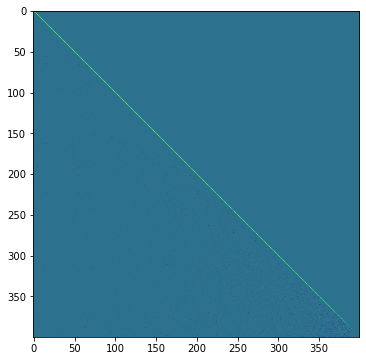

In [91]:
plt.imshow(precision_factor_L.numpy())

In [81]:
## normal HMC
# warmup - 100 n_samples - 1000 nls - 10 - min ess 14, psrf around 2 v. close to being ok took 5 hours
warmup_steps = 1000
n_samples = 1000
num_leapfrog_steps=10


step_size=np.float64(0.1)#*len_step,np.float64(0.1)*var_step]
#step_size=[np.float64(0.01)*np.exp(m.k_len_a.numpy()),np.float64(0.01)*np.exp(m.k_var_a.numpy())]
#step_size=[step_size2[0]*step_size[0],step_size2[1]*step_size[1]]
#step_size=np.float64(0.01)
n_chains=4
init_state = [tf.tile(tf.expand_dims((m.V_len),0),[n_chains,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_chains,1])]
#init_state = [mp+tf.random.normal(stddev=0.1,shape=mp.shape,dtype=tf.float64) for mp in init_state]

#step_size[0][182]*=100
#step_size=[np.float64(0.1)*np.ones((1,400)),np.float64(0.1)*np.ones((1,400))]
#step_size

In [92]:
init_state = [ss[-1] for ss in samples]
step_size

0.1

In [101]:
warmup_steps = 250
n_samples = 250
#kernel = tfp.mcmc.HamiltonianMonteCarlo(
kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,step_size=step_size, num_leapfrog_steps=num_leapfrog_steps,
                                                                    momentum_distribution=momentum_distribution)
#kernel = tfp.experimental.mcmc.PreconditionedNoUTurnSampler(target_log_prob_fn=m.model_log_prob,step_size=step_size, max_tree_depth=5,
#                                                                    momentum_distribution=momentum_distribution)
#kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=m.model_log_prob,step_size=step_size,max_tree_depth=6)#, num_leapfrog_steps=num_leapfrog_steps)

kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=warmup_steps)


pbar = tfp.experimental.mcmc.ProgressBarReducer(warmup_steps+ n_samples)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples, _, fkr = tfp.mcmc.sample_chain(num_results=n_samples,
                                                current_state=init_state,
                                                num_burnin_steps=warmup_steps,
                                                kernel=kernel,
                                                trace_fn=None,
                                                return_final_kernel_results=True)















  0%|          | 0/500 [00:00<?, ?it/s]









  0%|          | 1/500 [00:23<3:18:03, 23.81s/it]









  0%|          | 2/500 [00:32<2:04:57, 15.06s/it]









  1%|          | 3/500 [00:44<1:53:21, 13.69s/it]









  1%|          | 4/500 [00:56<1:47:31, 13.01s/it]









  1%|          | 5/500 [01:08<1:44:34, 12.68s/it]









  1%|          | 6/500 [01:21<1:43:04, 12.52s/it]









  1%|▏         | 7/500 [01:33<1:42:07, 12.43s/it]









  2%|▏         | 8/500 [01:45<1:41:08, 12.34s/it]









  2%|▏         | 9/500 [01:57<1:40:19, 12.26s/it]









  2%|▏         | 10/500 [02:09<1:39:49, 12.22s/it]









  2%|▏         | 11/500 [02:21<1:39:04, 12.16s/it]









  2%|▏         | 12/500 [02:33<1:38:25, 12.10s/it]









  3%|▎         | 13/500 [02:45<1:37:52, 12.06s/it]









  3%|▎         | 14/500 [02:57<1:37:55, 12.09s/it]









  3%|▎         | 15/500 [03:09<1:37:52, 12.11s/it]









  3%|▎         | 16/500 [03:21<1:37:30, 12.09s/it]

In [94]:
fkr.inner_results.new_step_size

<tf.Tensor: shape=(), dtype=float64, numpy=0.12961355962147042>

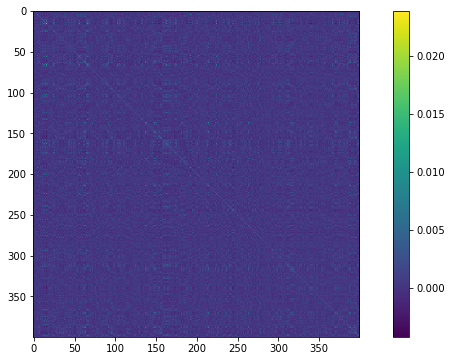

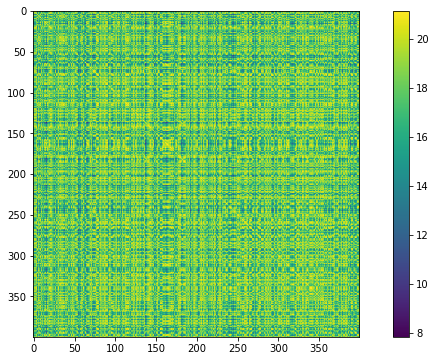

In [84]:
plt.imshow(np.cov(samples[0].numpy().reshape((-1,400)),rowvar=False))
plt.colorbar()

plt.show()
plt.imshow(K_len.numpy()[0])
plt.colorbar()
plt.show()

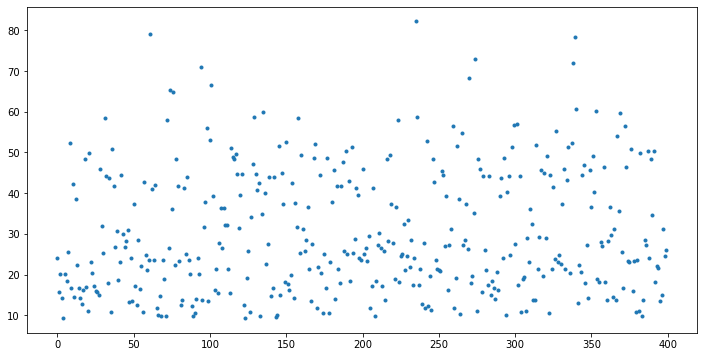

9.34081719650391

In [96]:
esses2 = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)) for ss in samples]
plt.plot(esses2[0],'.')
#plt.plot(esses[0],'.')

plt.show()
#plt.plot(esses[0],esses2[0],'.')
#plt.show()
esses2[0].min()

In [22]:
warmup_steps = 100
n_samples = 100
kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,
                                                                    num_leapfrog_steps=10,
                                                                    step_size=step_size,
                                                                    )

# Perform HMC in a 'decorrelated' space
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=[tfp.bijectors.ScaleMatvecTriL(scale_tril=L_len),
              tfp.bijectors.ScaleMatvecTriL(scale_tril=L_var)]
        )
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=warmup_steps)


pbar = tfp.experimental.mcmc.ProgressBarReducer(warmup_steps+ n_samples)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples, _, fkr = tfp.mcmc.sample_chain(num_results=n_samples,
                                                current_state=init_state,
                                                num_burnin_steps=warmup_steps,
                                                kernel=kernel,
                                                trace_fn=None,
                                                return_final_kernel_results=True)

#init_state = [ss[-1] for ss in samples]





100%|█████████▉| 199/200 [34:05<00:10, 10.36s/it]

In [24]:
fkr.inner_results.new_step_size

<tf.Tensor: shape=(), dtype=float64, numpy=0.0036105281124562552>

In [ ]:
# Set up the grid
num=20
x = np.linspace(0, 10, num,endpoint=False)[...,np.newaxis] 
y = np.linspace(0, 10, num,endpoint=False)[...,np.newaxis]
#Unew = np.zeros((num,2))
#Unew[:,0] = np.linspace(0, 10, num)
#Unew[:,1] = np.linspace(0, 10, num)
xx, yy = np.meshgrid(x, y, sparse=False)
x_grid = np.array([xx.flatten(), yy.flatten()])
print(x_grid.shape)


x_grid = x_grid.T
x_grid_r = x_grid.copy()
np.random.shuffle(x_grid_r)
#x_grid = x_grid.T

print(x_grid.shape)
#print(np.shape(X_grid))

#Load the data
df = pd.read_csv('../data/synthetic_data/positions_b2.csv')
T = df['Time'].values[:,None]
ID = df['ID'].values

X_x = df['Latitude'].values
X_y = df['Longitude'].values
X = np.zeros((len(X_x),2))
X[:,0] = X_x
X[:,1] = X_y

print(np.shape(X))
print(np.shape(T))
sigma = np.array(df['Sigma'].values).reshape(len(X_x),1)
beta = np.array(df['Beta'].values).reshape(len(X_x),1)

In [ ]:
# x_grid
# #np.random.shuffle(x_grid.T)
# x_grid

In [ ]:
m = GPMove(T,loadp['X_grid'],X,ID,BATCH_SIZE=500, domain=10.0, k_len_a=5.0, k_len_l=0.250, k_var_a=5, k_var_l=0.250)

In [ ]:
m.dist_optimize(iters=80,lr=1e-2)

In [ ]:
import pickle

b=2
param_dict ={'noise_variance':m.noise_variance.numpy(),
'X_grid':m.X_grid.numpy(),
'V_len':m.V_len.numpy(),
'V_len_mean':m.V_len_mean.numpy(),
'k_len_a':m.k_len_a.numpy(),
'k_len_l':m.k_len_l.numpy(),
'V_var':m.V_var.numpy(), 
'V_var_mean':m.V_var_mean.numpy(), 
'k_var_a': m.k_var_a.numpy(),
'k_var_l': m.k_var_l.numpy()} 
with open('../data/mcmc/synthetic_data_b_' + str(int(b)) + '_paraam_dict.pkl', 'wb') as f:
        pickle.dump(param_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
b=2
with open('../data/mcmc/synthetic_data_b_' + str(int(b)) + '_paraam_dict.pkl', 'rb') as f:
    loadp = pickle.load(f)

In [13]:
loadp['k_var_a']

array([2.51073373])

In [7]:
m.noise_variance.assign(loadp['noise_variance'])
m.V_len.assign(loadp['V_len'])
m.V_len_mean.assign(loadp['V_len_mean'])
m.k_len_a.assign(loadp['k_len_a'])
m.k_len_l.assign(loadp['k_len_l'])
m.V_var.assign(loadp['V_var'])
m.V_var_mean.assign(loadp['V_var_mean'])
m.k_var_a.assign(loadp['k_var_a'])
m.k_var_l.assign(loadp['k_var_l'])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float64, numpy=array([1.26801633])>

In [ ]:
# with tf.GradientTape() as t:
#     gp_p = m.gp_prior(m.V_len,m.V_var)
    
# print(tf.reduce_mean(tf.math.abs(t.gradient(gp_p,[m.V_len,m.V_var]))).numpy())

# with tf.GradientTape() as t:
#     dl = m.data_likelihood(m.V_len,m.V_var)
    
# print(tf.reduce_mean(tf.math.abs(t.gradient(dl,[m.V_len,m.V_var]))).numpy())
plt.plot(m.V_var.numpy())
plt.show()

In [ ]:
0.036/1.18

400/10000



offset = x_grid.shape[0]/X.shape[0] # estimate of relative difference between gp prior and data likelihood

print(offset)
with tf.GradientTape() as t:
    kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l),m.L)
    K_len = kernel_l.matrix(m.X_grid,m.X_grid)
    L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_len_v = tf.squeeze(tf.linalg.matmul(L_len, tf.expand_dims(m.V_len,-1)))
    f_norm = tf.norm(F_len_v)
grad_len = t.gradient(f_norm,[m.V_len])[0].numpy()
len_step = (offset+np.abs(grad_len))**-1

plt.plot(len_step)

#plt.plot(len_step2)

plt.show()
with tf.GradientTape() as t:
    kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l),m.L)
    K_var = kernel_v.matrix(m.X_grid,m.X_grid)
    L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_var_v = tf.squeeze(tf.linalg.matmul(L_var, tf.expand_dims(m.V_var,-1)))
    f_norm = tf.norm(F_var_v)
grad_var = t.gradient(f_norm,[m.V_var])[0].numpy()
var_step = (offset+np.abs(grad_var))**-1

#var_step = (0.500000+np.abs(grad_var))**-1
plt.plot(var_step)
#plt.plot(var_step2)
#plt.ylim(0,1)
plt.show()

In [ ]:
n_sample=10000
offset = x_grid.shape[0]/X.shape[0] # estimate of relative difference between gp prior and data likelihood

vrand = tf.Variable(tf.random.normal(shape=(m.V_len.shape[0],n_sample),dtype=tf.float64))

with tf.GradientTape() as t:
    kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l),m.L)
    K_len = kernel_l.matrix(m.X_grid,m.X_grid)
    L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_len_v = tf.squeeze(tf.linalg.matmul(L_len, vrand))
    f_norm = tf.norm(F_len_v)
    
gt= t.gradient(f_norm,[vrand])

grad_len = tf.reduce_mean(tf.math.abs(gt[0]),axis=-1).numpy()
#grad_len = t.gradient(f_norm,[vtest])[0].numpy()
len_step = (offset+np.abs(grad_len))**-1
#len_step = (0.0+np.abs(grad_len))**-1

plt.plot(len_step)


#plt.plot(len_step2)

plt.show()


vrand = tf.Variable(tf.random.normal(shape=(m.V_var.shape[0],n_sample),dtype=tf.float64))

with tf.GradientTape() as t:
    kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l),m.L)
    K_var = kernel_v.matrix(m.X_grid,m.X_grid)
    L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_var_v = tf.squeeze(tf.linalg.matmul(L_var, vrand))
    f_norm = tf.norm(F_var_v)
    
    
gt= t.gradient(f_norm,[vrand])

grad_var = tf.reduce_mean(tf.math.abs(gt[0]),axis=-1).numpy()
#grad_len = t.gradient(f_norm,[vtest])[0].numpy()
var_step = (offset+np.abs(grad_var))**-1

#var_step = (0.500000+np.abs(grad_var))**-1
plt.plot(var_step)
#plt.ylim(0,1)
plt.show()


In [ ]:
m.V_len.shape[0]

In [ ]:
with tf.GradientTape() as t:
    kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l),m.L)
    K_len = kernel_l.matrix(m.X_grid,m.X_grid)
    L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_len_v = tf.squeeze(tf.linalg.matmul(L_len, tf.expand_dims(m.V_len,-1)))
    f_norm = tf.norm(F_len_v)
grad_len = t.gradient(f_norm,[m.V_len])[0].numpy()
len_step = (0.04+np.abs(grad_len))**-1
#len_step = (0.0+np.abs(grad_len))**-1

plt.plot(len_step)

#plt.plot(len_step2)

plt.show()


with tf.GradientTape() as t:
    kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l),m.L)
    K_var = kernel_v.matrix(m.X_grid,m.X_grid)
    L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
    F_var_v = tf.squeeze(tf.linalg.matmul(L_var, tf.expand_dims(m.V_var,-1)))
    f_norm = tf.norm(F_var_v)
grad_var = t.gradient(f_norm,[m.V_var])[0].numpy()
var_step = (0.04+np.abs(grad_var))**-1

#var_step = (0.500000+np.abs(grad_var))**-1
plt.plot(var_step)
#plt.plot(var_step2)
#plt.ylim(0,1)
plt.show()

In [ ]:
#var_step.max()/var_step.min()

#yy.shape
#x_grid
#len_grid

In [ ]:
## normal HMC
# warmup - 100 n_samples - 1000 nls - 10 - min ess 14, psrf around 2 v. close to being ok took 5 hours
warmup_steps = 1000
n_samples = 1000
num_leapfrog_steps=10


step_size=np.float64(0.1)#*len_step,np.float64(0.1)*var_step]
#step_size=[np.float64(0.01)*np.exp(m.k_len_a.numpy()),np.float64(0.01)*np.exp(m.k_var_a.numpy())]
#step_size=[step_size2[0]*step_size[0],step_size2[1]*step_size[1]]
#step_size=np.float64(0.01)
n_chains=4
init_state = [tf.tile(tf.expand_dims((m.V_len),0),[n_chains,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_chains,1])]
#init_state = [mp+tf.random.normal(stddev=0.1,shape=mp.shape,dtype=tf.float64) for mp in init_state]

#step_size[0][182]*=100

step_size

In [ ]:
tf.math.exp(m.k_var_a)
m.V_len

rand_len = tf.random.normal(shape=(m.num_grid,1), dtype=tf.float64)

kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l),m.L)
K_len = kernel_l.matrix(m.X_grid,m.X_grid)
L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)
F_len_v = tf.squeeze(tf.linalg.matmul(L_len, rand_len))

In [ ]:
tf.Variable(F_len_v)

In [ ]:


kernel_l = m.kern_len(tf.math.exp(m.k_len_a), tf.math.exp(m.k_len_l),m.L)
K_len = kernel_l.matrix(m.X_grid,m.X_grid)
L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)

kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l),m.L)
K_var = kernel_v.matrix(m.X_grid,m.X_grid)
L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6)

#x = tf.linalg.cholesky(true_cov)
identity_matrix =  tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64)
# Note `matrix_triangular_solve` implicitly zeros upper triangular of `x`.
y = tf.linalg.triangular_solve(L_len, identity_matrix)
y = tf.matmul(y, y, adjoint_a=True)
precision_factor_L = tf.linalg.cholesky(y)

y = tf.linalg.triangular_solve(L_var, identity_matrix)
y = tf.matmul(y, y, adjoint_a=True)
precision_factor_V = tf.linalg.cholesky(y)

tfd_e = tfp.experimental.distributions

tfd = tfp.distributions
#precision_factor_L = tf.linalg.cholesky(tf.linalg.inv(K_len + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6) + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-3)
#precision_factor_V = tf.linalg.cholesky(tf.linalg.inv(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-6) + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-3)

#precision_factor = L_var#tf.linalg.cholesky(precision + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-2)
# momentum_distribution = tfp.experimental.as_composite(
# tfp.distributions.JointDistributionSequential([
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_len),
# ), 
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_var),
# )
    
# ]))


momentum_distribution = tfp.experimental.as_composite(
tfp.distributions.JointDistributionSequential([
    tfd.MultivariateNormalTriL(
    loc=0, scale_tril=precision_factor_L
    
), 
    tfd.MultivariateNormalTriL(
    loc=0    , scale_tril=precision_factor_V
)
    
]))


# moomentum_distribution = tfp.distributions.JointDistributionSequential([
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_len),
# ), 
#     tfd_e.MultivariateNormalPrecisionFactorLinearOperator(
#     loc=0,
#     precision_factor=tf.linalg.LinearOperatorLowerTriangular(L_var),
# )
    
# ])

In [ ]:
# momentum_distribution.sample()
# init_state
#momentum_distribution.sample()
2**6
step_size

In [ ]:
warmup_steps = 100
n_samples = 100
kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,
                                                                    num_leapfrog_steps=10,
                                                                    step_size=step_size,
                                                                    )

# # Perform HMC in a 'decorrelated' space
# kernel = tfp.mcmc.TransformedTransitionKernel(
#     inner_kernel=kernel,
#     bijector=[tfp.bijectors.AffineLinearOperator(
#         scale=tf.linalg.LinearOperatorLowerTriangular(
#             L_len)),tfp.bijectors.AffineLinearOperator(
#         scale=tf.linalg.LinearOperatorLowerTriangular(
#             L_var))]
#         )
# Perform HMC in a 'decorrelated' space
kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=[tfp.bijectors.ScaleMatvecTriL(scale_tril=L_len),
              tfp.bijectors.ScaleMatvecTriL(scale_tril=L_var)]
        )
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=warmup_steps)


pbar = tfp.experimental.mcmc.ProgressBarReducer(warmup_steps+ n_samples)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples, _, fkr = tfp.mcmc.sample_chain(num_results=n_samples,
                                                current_state=init_state,
                                                num_burnin_steps=warmup_steps,
                                                kernel=kernel,
                                                trace_fn=None,
                                                return_final_kernel_results=True)

#init_state = [ss[-1] for ss in samples]




In [ ]:
warmup_steps = 100
n_samples = 100
#kernel = tfp.mcmc.HamiltonianMonteCarlo(
kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,step_size=step_size, num_leapfrog_steps=num_leapfrog_steps,
                                                                    momentum_distribution=momentum_distribution)
#kernel = tfp.experimental.mcmc.PreconditionedNoUTurnSampler(target_log_prob_fn=m.model_log_prob,step_size=step_size, max_tree_depth=5,
#                                                                    momentum_distribution=momentum_distribution)
#kernel = tfp.mcmc.NoUTurnSampler(target_log_prob_fn=m.model_log_prob,step_size=step_size,max_tree_depth=6)#, num_leapfrog_steps=num_leapfrog_steps)

kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=warmup_steps)


pbar = tfp.experimental.mcmc.ProgressBarReducer(warmup_steps+ n_samples)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples, _, fkr = tfp.mcmc.sample_chain(num_results=n_samples,
                                                current_state=init_state,
                                                num_burnin_steps=warmup_steps,
                                                kernel=kernel,
                                                trace_fn=None,
                                                return_final_kernel_results=True)

#init_state = [ss[-1] for ss in samples]




In [102]:
#fkr
essesmin = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)).min() for ss in samples]
essesmin
#fkr

[45.01606007927335, 12.488364751155514]

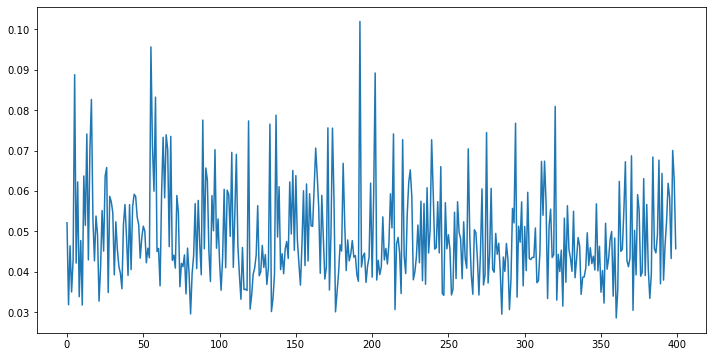

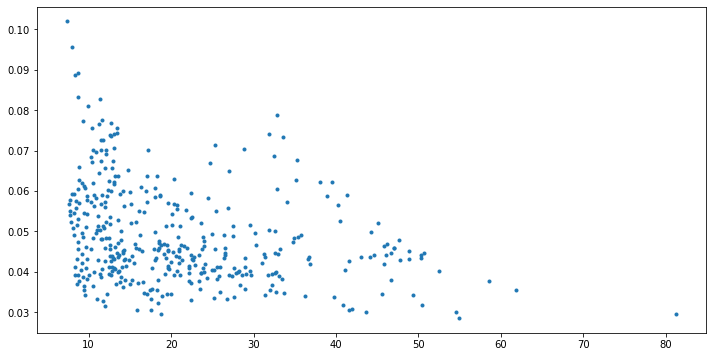

In [42]:
step_size = [np.std(ss.numpy(),axis=(0,1)) for ss in samples]
plt.plot(step_size[1])#,step_size[0],'.')
plt.show()

plt.plot(esses2[1],step_size[1],'.')
plt.show()

# plt.plot(step_size3[0]/step_size2[0],'.')
# plt.show()

In [ ]:
step_size3[0].max()/step_size3[0].min()

In [ ]:
#plt.plot(step_size[0],'.')
plt.plot(step_size2[0],step_size[0],'.')
plt.show()
step_size2[0][213]
step_size[0][213]

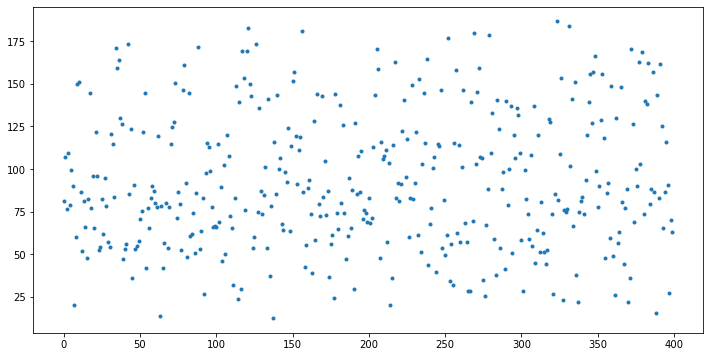

In [104]:
esses2 = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)) for ss in samples]
plt.plot(esses2[1],'.')
#plt.plot(esses[0],'.')

plt.show()
#plt.plot(esses[0],esses2[0],'.')
#plt.show()

In [105]:
#samples
esses2[1]

array([ 80.9535435 , 107.09370338,  76.58279735, 109.19811717,
        78.90800782,  99.61615789,  89.97664233,  19.88466646,
        60.21696684, 149.89148879, 151.30254556,  86.37865856,
        51.91699939,  80.99274488,  65.80950483,  47.54284623,
        82.64635971, 144.6727599 ,  76.8755969 ,  95.86811697,
        65.56485228, 121.96405021,  96.096916  ,  52.16884466,
        54.06550958,  82.38951371,  61.93706052,  94.84450901,
        78.43032577,  57.32593256,  54.24141093, 120.60836871,
       114.65070329,  83.29855747, 171.13348489, 159.09728882,
       163.76182046, 129.75548906, 126.29965102,  46.99021495,
        53.03991257,  56.01899265, 173.33508158,  85.21241919,
       123.5388582 ,  35.76558689,  90.37201541,  53.2197389 ,
        54.49962421,  57.61703514,  70.80605721,  75.0371862 ,
       121.94370752, 144.55198412,  41.74311305,  77.0881499 ,
        65.55183556,  83.01505651,  90.07196231,  86.82916464,
        80.07166551,  77.68962161, 119.45813297,  13.37

In [ ]:
esses = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)) for ss in samples]
plt.plot(esses[1],'.')
esses[0].argmin()

In [ ]:
essesmin = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)).min() for ss in samples]
essesmax = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)).max() for ss in samples]
essesmean = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)).mean() for ss in samples]

print('ess min:', essesmin, flush=True)
print('ess max:', essesmax, flush=True)
print('ess mean:', essesmean, flush=True)

In [ ]:
essesmin = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)).min() for ss in samples]
essesmax = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)).max() for ss in samples]
essesmean = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=1).numpy().reshape((-1)).mean() for ss in samples]
print('ss2')
print('ess min:', essesmin, flush=True)
print('ess max:', essesmax, flush=True)
print('ess mean:', essesmean, flush=True)

In [ ]:
essesmin = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=None).numpy().reshape((-1)).min() for ss in samples]
essesmax = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=None).numpy().reshape((-1)).max() for ss in samples]
essesmean = [tfp.mcmc.effective_sample_size(ss,cross_chain_dims=None).numpy().reshape((-1)).mean() for ss in samples]

print('ess min:', essesmin, flush=True)
print('ess max:', essesmax, flush=True)
print('ess mean:', essesmean, flush=True)

In [ ]:
tfp.mcmc.potential_scale_reduction(samples[0])

In [ ]:
tfp.mcmc.effective_sample_size(ss).numpy().shape
samples[0][:,0,:].shape

In [ ]:
fkr.inner_results.new_step_size

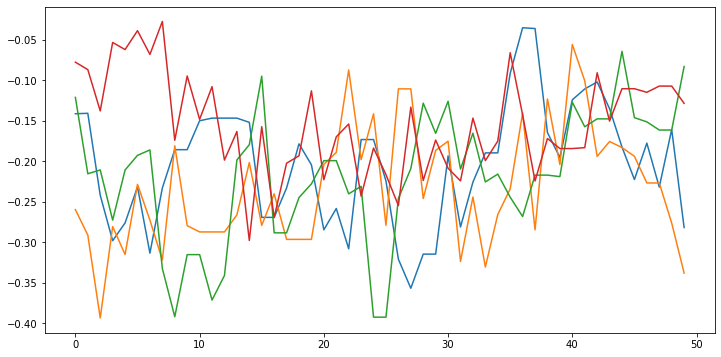

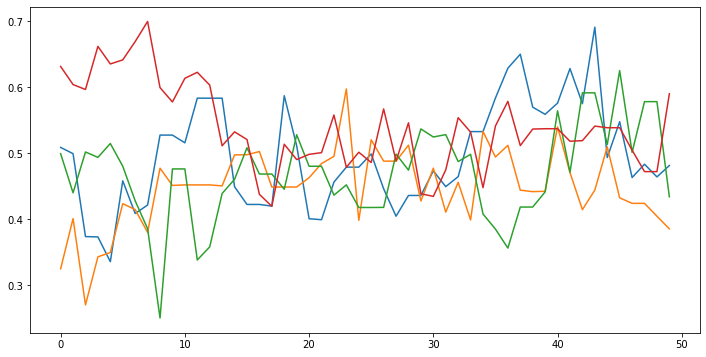

In [100]:
j=2

for ss in samples:
    plt.plot(ss[:,:,0])
    plt.show()

In [ ]:
step_size[0][170]

In [ ]:
plt.plot(step_size[0])
plt.plot(step_size[1])
plt.show()

In [ ]:
plt.plot(step_size[1])
plt.show()

step_size2 = [np.std(ss.numpy()[:,0,:],axis=0) for ss in samples]
plt.plot(step_size2[1],'.')
plt.show()

In [ ]:
plt.plot(step_size[1])
#plt.show()

step_size2 = [np.std(ss.numpy()[:,0,:],axis=0) for ss in samples]
plt.plot(step_size2[1],'.')
plt.show()

In [ ]:


# warm-up run
num_warmup = 100
warmup_steps = 1000
n_samples = 50
num_leapfrog_steps=5
step_size=np.float64(0.005)
n_chains=10
init_state = [tf.tile(tf.expand_dims((m.V_len),0),[n_chains,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_chains,1])]
init_state = [m+tf.random.normal(stddev=0.1,shape=m.shape,dtype=tf.float64) for m in init_state]
momentum_distribution=None

initial_running_variance = [tfp.experimental.stats.RunningVariance.from_stats(
                                        num_samples=np.float64(1), mean=(mt), variance=tf.ones_like(mt)) for mt in [m.V_len,m.V_var]]


In [ ]:

kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,
                                                                        num_leapfrog_steps=num_leapfrog_steps,
                                                                        step_size=step_size,
                                                                        store_parameters_in_results=True,
                                                                        momentum_distribution=momentum_distribution)




kernel = tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(inner_kernel=kernel,initial_running_variance=initial_running_variance)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=n_samples)

pbar = tfp.experimental.mcmc.ProgressBarReducer(n_samples-1)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples, _, fkr = tfp.mcmc.sample_chain(num_results=n_samples,
                                                current_state=init_state,
                                                kernel=kernel,
                                                trace_fn=None,
                                                return_final_kernel_results=True)


In [ ]:
step_size = fkr.inner_results.inner_results.inner_results.accepted_results.s
running_variance = fkr.inner_results.inner_results.running_variance
 
f_samples = [m.predict_length(samples[0]),m.predict_var(samples[1])]
essesmin = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).min() f
essesmax = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).max() f
essesmean = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).mean()

print('ess min:', essesmin, flush=True)
print('ess max:', essesmax, flush=True)
print('ess mean:', essesmean, flush=True)
print('step:' , step_size)
 
init_state = [ss[-1] for ss in samples]
initial_running_variance = [tfp.experimental.stats.RunningVariance.from_stat
                                     num_samples=np.float64(10.),
                                     mean=rv.mean,
                                     variance=rv.variance()) for rv in running_va
esses = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).min() for


In [ ]:
init_state = [ss[-1] for ss in samples]
n_samples = 100

momentum_distribution = fkr.inner_results.inner_results.inner_results.accepted_results.momentum_distribution
step_size = fkr.inner_results.inner_results.inner_results.accepted_results.step_size
kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,
                                                                        num_leapfrog_steps=num_leapfrog_steps,
                                                                        step_size=step_size,
                                                                        store_parameters_in_results=True,
                                                                        momentum_distribution=momentum_distribution)
pbar = tfp.experimental.mcmc.ProgressBarReducer(n_samples-1)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples, _, fkr = tfp.mcmc.sample_chain(num_results=n_samples,
                                                current_state=init_state,
                                                kernel=kernel,
                                                trace_fn=None,
                                                return_final_kernel_results=True)

In [ ]:
j=1
       
for ss in samples2:
    plt.plot(ss[:,j,:,0])
    plt.show()



In [ ]:
# warm-up run
num_warmup = 100
warmup_steps = 1000
n_samples = 500
num_leapfrog_steps=5
step_size=np.float64(0.005)
n_chains=10
init_state = [tf.tile(tf.expand_dims((m.V_len),0),[n_chains,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_chains,1])]
init_state = [m+tf.random.normal(stddev=0.1,shape=m.shape,dtype=tf.float64) for m in init_state]
momentum_distribution=None
initial_running_variance = [tfp.experimental.stats.RunningVariance.from_stats(
                                        num_samples=np.float64(1), mean=(mt), variance=tf.ones_like(mt)) for mt in [m.V_len,m.V_var]]
kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(target_log_prob_fn=m.model_log_prob,
                                                                        num_leapfrog_steps=num_leapfrog_steps,
                                                                        step_size=step_size,
                                                                        store_parameters_in_results=True,
                                                                        momentum_distribution=momentum_distribution)




kernel = tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(inner_kernel=kernel,initial_running_variance=initial_running_variance)
kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=n_samples)

pbar = tfp.experimental.mcmc.ProgressBarReducer(n_samples-1)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

samples, _, fkr = tfp.mcmc.sample_chain(num_results=n_samples,
                                                current_state=init_state,
                                                kernel=kernel,
                                                trace_fn=None,
                                                return_final_kernel_results=True)

In [ ]:
    def run_hmc(steps, init_value, step_size, max_tree_depth=10,warmuprun=True,momentum_distribution=None,initial_running_variance=None):

        kernel = tfp.experimental.mcmc.PreconditionedHamiltonianMonteCarlo(target_log_prob_fn=m.likelihood_fn,
                                                                        num_leapfrog_steps=num_leapfrog_steps,
                                                                        step_size=step_size,
                                                                        store_parameters_in_results=True,
                                                                        momentum_distribution=momentum_distribution)





        #kernel = tfp.experimental.mcmc.PreconditionedNoUTurnSampler(target_log_prob_fn=m.likelihood_fn,
        #                                                                max_tree_depth=max_tree_depth,
        #                                                                step_size=step_size,
        #                                                                momentum_distribution=momentum_distribution)

        if warmuprun:
            #print(initial_running_variance)
            kernel = tfp.experimental.mcmc.DiagonalMassMatrixAdaptation(inner_kernel=kernel,initial_running_variance=initial_running_variance)
            kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=steps)

        pbar = tfp.experimental.mcmc.ProgressBarReducer(steps-1)
        kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

        samples, _, fkr = tfp.mcmc.sample_chain(num_results=steps,
                                                        current_state=init_value,
                                                        kernel=kernel,
                                                        trace_fn=None,
                                                        return_final_kernel_results=True)
        return samples, fkr


    # warm-up run
    num_warmup = 100
    warmup_steps = 1000
    n_samples = 500
    num_leapfrog_steps=5
    step_size=np.float64(0.005)
    init_value = m.trainable_parameters
    initial_running_variance = [tfp.experimental.stats.RunningVariance.from_stats(
                                            num_samples=np.float64(1), mean=(mt), variance=tf.ones_like(mt)) for mt in m.trainable_parameters]

    for i in range(num_warmup):
        print('\nstarting warmup run '+ str(i) + '\n', flush=True)
        samples, fkr = run_hmc(warmup_steps,init_value, step_size,max_tree_depth=6+i,initial_running_variance=initial_running_variance)
        step_size = fkr.inner_results.inner_results.inner_results.accepted_results.step_size
        running_variance = fkr.inner_results.inner_results.running_variance
        #for rv in running_variance:
        #    print(rv.mean,rv.variance())

        essesmin = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).min() for ss in samples]
        essesmax = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).max() for ss in samples]
        essesmean = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).mean() for ss in samples]

        print('ess min:', essesmin, flush=True)
        print('ess max:', essesmax, flush=True)
        print('ess mean:', essesmean, flush=True)
        print('step:' , step_size)

        init_value = [ss[-1] for ss in samples]
        initial_running_variance = [tfp.experimental.stats.RunningVariance.from_stats(
                                        num_samples=np.float64(1.),
                                        mean=rv.mean,
                                        variance=rv.variance()) for rv in running_variance]
        esses = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).min() for ss in samples]
        if min(esses)>0.5*warmup_steps:
            print('\nthreshold ess reached. Starting full run...\n ', flush=True)
            break


    momentum_distribution = fkr.inner_results.inner_results.inner_results.accepted_results.momentum_distribution
    samples, fkr = run_hmc(n_samples,init_value,step_size,warmuprun=False,momentum_distribution=momentum_distribution)
    esses = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).min() for ss in samples]

    print('final ess :', esses, flush=True)


In [ ]:
#[tf.random.normal(stddev=0.1,shape=m[0].shape,dtype=tf.float64) for m in init_state]

In [ ]:
#help(tf.random.normal)

In [ ]:

adapt_steps = 200
n_samples = 200
total_steps = adapt_steps + n_samples 

decay_rate=0.6
minT=(m.X_grid.shape[0]/X.shape[0])/100
n_rep =round(np.log(minT)/np.log(decay_rate))+1

#minT = m.gp_prior(m.V_len,m.V_var).numpy()[0]/(1000*m.data_likelihood(m.V_len,m.V_var).numpy())

# round(-np.log(minT))+1

num_leapfrog_steps=3
state = [tf.tile(tf.expand_dims((m.V_len),0),[n_rep,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_rep,1])]

#inverse_temperatures =tf.constant(np.exp(-np.arange(n_rep)))
inverse_temperatures = decay_rate**(tf.range(n_rep, dtype=tf.float64))

print(inverse_temperatures)
step_size = 0.005 / tf.reshape(tf.sqrt(inverse_temperatures), shape=(n_rep, 1))

def make_kernel_fn(target_log_prob_fn):
    kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn,step_size=step_size, num_leapfrog_steps=num_leapfrog_steps)
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=adapt_steps)
    return kernel

remc = tfp.mcmc.ReplicaExchangeMC(target_log_prob_fn=None,
    untempered_log_prob_fn=m.gp_prior, tempered_log_prob_fn=m.data_likelihood,
    inverse_temperatures=inverse_temperatures,state_includes_replicas=True,
    swap_proposal_fn=tfp.mcmc.even_odd_swap_proposal_fn(1.0),
    make_kernel_fn=make_kernel_fn)



pbar = tfp.experimental.mcmc.ProgressBarReducer(adapt_steps+n_samples-1)
kernel = tfp.experimental.mcmc.WithReductions(remc, pbar)


def trace_swaps(unused_state, results):
    return (results.inner_results.is_swap_proposed_adjacent, results.inner_results.is_swap_accepted_adjacent)

samples,(is_swap_proposed_adjacent, is_swap_accepted_adjacent) ,fkr = tfp.mcmc.sample_chain(
    num_results=n_samples,
    current_state=state,
    kernel=kernel,
    trace_fn=trace_swaps,
    num_burnin_steps=adapt_steps,return_final_kernel_results=True)


conditional_swap_prob = (tf.reduce_sum(tf.cast(is_swap_accepted_adjacent, tf.float32), axis=0)/
                            tf.reduce_sum(tf.cast(is_swap_proposed_adjacent, tf.float32), axis=0))


In [ ]:
conditional_swap_prob

In [ ]:
minT = m.gp_prior(m.V_len,m.V_var).numpy()[0]/(1000*m.data_likelihood(m.V_len,m.V_var).numpy())


In [ ]:

400/(20000*100)

In [ ]:
momentum_distribution.stddev()

In [ ]:
0.001
0.5**9
inverse_temperatures

In [ ]:
samples2 = [m.predict_length(samples[0]),m.predict_var(samples[1])]

In [ ]:
j=1
       
for ss in samples2:
    plt.plot(ss[:,j,:,0])
    plt.show()
essesmin = [tfp.mcmc.effective_sample_size(ss[:,j,:]).numpy().reshape((-1)).min() for ss in samples2]
essesmax = [tfp.mcmc.effective_sample_size(ss[:,j,:]).numpy().reshape((-1)).max() for ss in samples2]
essesmean = [tfp.mcmc.effective_sample_size(ss[:,j,:]).numpy().reshape((-1)).mean() for ss in samples2]
 
print('ess min:', essesmin, flush=True)
print('ess max:', essesmax, flush=True)
print('ess mean:', essesmean, flush=True)

In [ ]:
tfp.mcmc.effective_sample_size(samples[0],cross_chain_dims=1)

In [ ]:
len_grid=m.predict_length(samples[0][-1,0]).numpy().reshape((20,20))
plt.contourf(xx,yy,len_grid,levels=100)


In [ ]:
samples[0]

In [ ]:



adapt_steps = 100
n_samples = 100
total_steps = adapt_steps + n_samples 



new_step_size = [np.std(ss.numpy(),axis=0) for ss in samples]


def make_kernel_fn(target_log_prob_fn):
    kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn,step_size=new_step_size, num_leapfrog_steps=num_leapfrog_steps)
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=adapt_steps)
    return kernel

remc = tfp.mcmc.ReplicaExchangeMC(target_log_prob_fn=None,
    untempered_log_prob_fn=m.gp_prior, tempered_log_prob_fn=m.data_likelihood,
    inverse_temperatures=inverse_temperatures,state_includes_replicas=True,
    swap_proposal_fn=tfp.mcmc.even_odd_swap_proposal_fn(1.0),
    make_kernel_fn=make_kernel_fn)


pbar = tfp.experimental.mcmc.ProgressBarReducer(adapt_steps+n_samples-1)
kernel = tfp.experimental.mcmc.WithReductions(remc, pbar)


def trace_swaps(unused_state, results):
    return (results.inner_results.is_swap_proposed_adjacent, results.inner_results.is_swap_accepted_adjacent)

samples,(is_swap_proposed_adjacent, is_swap_accepted_adjacent) ,fkr = tfp.mcmc.sample_chain(
    num_results=n_samples,
    current_state=state,
    kernel=kernel,
    trace_fn=trace_swaps,
    num_burnin_steps=adapt_steps,return_final_kernel_results=True)


conditional_swap_prob = (tf.reduce_sum(tf.cast(is_swap_accepted_adjacent, tf.float32), axis=0)/
                            tf.reduce_sum(tf.cast(is_swap_proposed_adjacent, tf.float32), axis=0))


In [ ]:
inverse_temperatures

In [ ]:
np.exp(round(np.log(minT)))

In [ ]:
minT = m.gp_prior(m.V_len,m.V_var).numpy()[0]/(1000*m.data_likelihood(m.V_len,m.V_var).numpy())
minT


In [ ]:
minT = np.exp(round(np.log(minT)))

adapt_steps = 50
thin = 1
n_samples = 10
total_steps = adapt_steps + (thin+1)*n_samples 

def test_log_prob(V_len,V_var):
    return m.gp_prior(V_len,V_var)+0.0002*m.data_likelihood(V_len,V_var)
    

num_leapfrog_steps=5
step_size=np.float64(0.01)
state = [tf.expand_dims(m.V_len,0),tf.expand_dims(m.V_var,0)]

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=test_log_prob,
    num_leapfrog_steps=num_leapfrog_steps,
    step_size=step_size,
    store_parameters_in_results=True)


kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=adapt_steps)

pbar = tfp.experimental.mcmc.ProgressBarReducer(total_steps-1)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

draws, chain_state,fkr = tfp.mcmc.sample_chain(
        num_results=n_samples,
        num_burnin_steps=adapt_steps,
        num_steps_between_results=thin,
        current_state=state,
        kernel=kernel,
        return_final_kernel_results=True)

full_step_size = fkr.inner_results.inner_results.accepted_results.step_size


In [ ]:
for ss in draws:
    plt.plot(ss[:,-1,:])
    plt.show()

In [ ]:
for ss in draws:
    plt.plot(ss[:,-1,:])
    plt.show()

In [ ]:
f_len = m.predict_length(draws[0][:,0,:])

f_len = f_len.numpy().reshape(10,num,num)


plt.contourf(xx,yy,f_len[1],levels=100)
plt.colorbar()
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Optimized kernel lengthscale')
plt.show()


In [ ]:
f_len

In [ ]:
# adapt_steps = 500
# thin = 1
# n_samples = 20
# total_steps = adapt_steps + thin*n_samples 


# num_leapfrog_steps=3
# step_size=np.float64(0.01)
# state = [tf.expand_dims(m.V_len,0),tf.expand_dims(m.V_var,0)]

# kernel = tfp.mcmc.HamiltonianMonteCarlo(
#     target_log_prob_fn=m.gp_prior,
#     num_leapfrog_steps=num_leapfrog_steps,
#     step_size=step_size,
#     store_parameters_in_results=True)


# kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=adapt_steps)

# pbar = tfp.experimental.mcmc.ProgressBarReducer(total_steps-1)
# kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)

# draws, chain_state,fkr = tfp.mcmc.sample_chain(
#         num_results=n_samples,
#         num_burnin_steps=adapt_steps,
#         num_steps_between_results=thin,
#         current_state=state,
#         kernel=kernel,
#         return_final_kernel_results=True)

# prior_step_size = fkr.inner_results.inner_results.accepted_results.step_size


In [ ]:
# #print(full_step_size.numpy())
# print(prior_step_size.numpy())
# #help(np.geomspace)

In [ ]:
# step_size = tf.reshape(np.geomspace(full_step_size.numpy(),prior_step_size.numpy(),4,endpoint=False),shape=(4,1))
# step_size

In [ ]:
#inverse_temperatures

In [ ]:

adapt_steps = 250#500
#thin = 10
n_samples = 500#00#500
total_steps = adapt_steps + thin*n_samples 
n_rep = 20

num_leapfrog_steps=10
#step_size=np.float64(0.01)
state = [tf.tile(tf.expand_dims((m.V_len),0),[n_rep,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_rep,1])]
#momentum_distribution = None

#inverse_temperatures = 0.6**tf.range(n_rep, dtype=tf.float64)
#inverse_temperatures = 0.5**(tf.range(n_rep, dtype=tf.float64)**1.0)
#inverse_temperatures=inverse_temperatures*tf.constant([1,1,1,0],dtype=tf.float64)
minT = m.gp_prior(m.V_len,m.V_var).numpy()[0]/(100*m.data_likelihood(m.V_len,m.V_var).numpy())

inverse_temperatures =tf.constant(np.geomspace(1.0,minT,n_rep))

# step_size must broadcast with all batch and event dimensions of target.
# Here, this means it must broadcast with:
#  [len(inverse_temperatures)] + target.event_shape
step_size = 0.005 / tf.reshape(tf.sqrt(inverse_temperatures), shape=(n_rep, 1))

#step_size = 0.5*step_size.numpy() * tf.reshape(1+tf.range(4, dtype=tf.float64), shape=(4, 1))
#step_size = tf.reshape(np.geomspace(full_step_size.numpy(),prior_step_size.numpy(),n_rep,endpoint=False),shape=(4,1))

def make_kernel_fn(target_log_prob_fn):
    kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn,step_size=step_size, num_leapfrog_steps=num_leapfrog_steps)
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=adapt_steps)
    return kernel


remc = tfp.mcmc.ReplicaExchangeMC(target_log_prob_fn=None,
    untempered_log_prob_fn=m.gp_prior, tempered_log_prob_fn=m.data_likelihood,
    inverse_temperatures=inverse_temperatures,state_includes_replicas=True,
    swap_proposal_fn=tfp.mcmc.even_odd_swap_proposal_fn(1.0),
    make_kernel_fn=make_kernel_fn)



pbar = tfp.experimental.mcmc.ProgressBarReducer(adapt_steps+n_samples-1)
kernel = tfp.experimental.mcmc.WithReductions(remc, pbar)


def trace_swaps(unused_state, results):
  return (results.inner_results.is_swap_proposed_adjacent,
          results.inner_results.is_swap_accepted_adjacent)

samples,(is_swap_proposed_adjacent, is_swap_accepted_adjacent) ,fkr = tfp.mcmc.sample_chain(
    num_results=n_samples,
    current_state=state,
    kernel=kernel,
    trace_fn=trace_swaps,
    num_burnin_steps=adapt_steps,return_final_kernel_results=True)


# conditional_swap_prob[k] = P[ExchangeAccepted | ExchangeProposed],
# for the swap between replicas k and k+1.
conditional_swap_prob = (
    tf.reduce_sum(tf.cast(is_swap_accepted_adjacent, tf.float32), axis=0)
    /
    tf.reduce_sum(tf.cast(is_swap_proposed_adjacent, tf.float32), axis=0))


In [ ]:
conditional_swap_prob

In [ ]:
np.std(samples[0].numpy(),axis=0).shape

In [ ]:
step_size2 = [np.std(ss.numpy(),axis=0) for ss in samples]

In [ ]:

adapt_steps = 20#500
#thin = 10
n_samples = 50#00#500
total_steps = adapt_steps + thin*n_samples 
n_rep = 20

num_leapfrog_steps=3
#step_size=np.float64(0.01)
state = [tf.tile(tf.expand_dims((m.V_len),0),[n_rep,1]),tf.tile(tf.expand_dims((m.V_var),0),[n_rep,1])]
#momentum_distribution = None

# #inverse_temperatures = 0.6**tf.range(n_rep, dtype=tf.float64)
# #inverse_temperatures = 0.5**(tf.range(n_rep, dtype=tf.float64)**1.0)
# #inverse_temperatures=inverse_temperatures*tf.constant([1,1,1,0],dtype=tf.float64)
# minT = m.gp_prior(m.V_len,m.V_var).numpy()[0]/(100*m.data_likelihood(m.V_len,m.V_var).numpy())

# inverse_temperatures =tf.constant(np.geomspace(1.0,minT,n_rep))

# step_size must broadcast with all batch and event dimensions of target.
# Here, this means it must broadcast with:
#  [len(inverse_temperatures)] + target.event_shape
#step_size = 0.005 / tf.reshape(tf.sqrt(inverse_temperatures), shape=(n_rep, 1))

#step_size = 0.5*step_size.numpy() * tf.reshape(1+tf.range(4, dtype=tf.float64), shape=(4, 1))
#step_size = tf.reshape(np.geomspace(full_step_size.numpy(),prior_step_size.numpy(),n_rep,endpoint=False),shape=(4,1))

def make_kernel_fn(target_log_prob_fn):
    kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn,step_size=step_size2, num_leapfrog_steps=num_leapfrog_steps)
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=adapt_steps)
    return kernel


remc = tfp.mcmc.ReplicaExchangeMC(target_log_prob_fn=None,
    untempered_log_prob_fn=m.gp_prior, tempered_log_prob_fn=m.data_likelihood,
    inverse_temperatures=inverse_temperatures,state_includes_replicas=True,
    swap_proposal_fn=tfp.mcmc.even_odd_swap_proposal_fn(1.0),
    make_kernel_fn=make_kernel_fn)



pbar = tfp.experimental.mcmc.ProgressBarReducer(adapt_steps+n_samples-1)
kernel = tfp.experimental.mcmc.WithReductions(remc, pbar)


def trace_swaps(unused_state, results):
  return (results.inner_results.is_swap_proposed_adjacent,
          results.inner_results.is_swap_accepted_adjacent)

samples,(is_swap_proposed_adjacent, is_swap_accepted_adjacent) ,fkr = tfp.mcmc.sample_chain(
    num_results=n_samples,
    current_state=state,
    kernel=kernel,
    trace_fn=trace_swaps,
    num_burnin_steps=adapt_steps,return_final_kernel_results=True)


# conditional_swap_prob[k] = P[ExchangeAccepted | ExchangeProposed],
# for the swap between replicas k and k+1.
conditional_swap_prob = (
    tf.reduce_sum(tf.cast(is_swap_accepted_adjacent, tf.float32), axis=0)
    /
    tf.reduce_sum(tf.cast(is_swap_proposed_adjacent, tf.float32), axis=0))


In [ ]:
step_size2[0].shape

In [ ]:
fkr.inner_results.pre_swap_replica_results.inner_results.accepted_results.step_size

In [ ]:
step_size/3.3

In [ ]:
inverse_temperatures#=inverse_temperatures*tf.constant([1,1,1,0],dtype=tf.float64)

In [ ]:
inverse_temperatures

In [ ]:
       
for ss in samples:
    plt.plot(ss[:,-1,:])
    plt.show()

In [ ]:
j=7
       
for ss in samples:
    plt.plot(ss[:,0,:])
    plt.show()
essesmin = [tfp.mcmc.effective_sample_size(ss[:,j,:]).numpy().reshape((-1)).min() for ss in samples]
essesmax = [tfp.mcmc.effective_sample_size(ss[:,j,:]).numpy().reshape((-1)).max() for ss in samples]
essesmean = [tfp.mcmc.effective_sample_size(ss[:,j,:]).numpy().reshape((-1)).mean() for ss in samples]
 
print('ess min:', essesmin, flush=True)
print('ess max:', essesmax, flush=True)
print('ess mean:', essesmean, flush=True)

In [ ]:
esses = [tfp.mcmc.effective_sample_size(ss[:,0,:]).numpy().reshape((-1)) for ss in samples]

for ss in esses:
    plt.plot(ss)
    plt.show()

In [ ]:
esses

In [ ]:
essesmin = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).min() for ss in samples]
essesmax = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).max() for ss in samples]
essesmean = [tfp.mcmc.effective_sample_size(ss).numpy().reshape((-1)).mean() for ss in samples]

print('ess min:', essesmin, flush=True)
print('ess max:', essesmax, flush=True)
print('ess mean:', essesmean, flush=True)

In [ ]:
m.gp_prior(V_len,V_var)
#V_len

In [ ]:
kernel_v = m.kern_var(tf.math.exp(m.k_var_a), tf.math.exp(m.k_var_l), m.L)
K_var = kernel_v.matrix(m.X_grid,m.X_grid)
L_var = tf.linalg.cholesky(K_var + tf.eye(tf.shape(m.X_grid)[0], dtype=tf.float64) * 1e-5)
F_var_v = tf.squeeze(tf.linalg.matmul(L_var, tf.expand_dims(V_var,-1)))
logpdf_K_var =  tfd.MultivariateNormalTriL(loc=np.float64(0), scale_tril = L_var).log_prob((F_var_v))

#         kernel_l = self.kern_len(tf.math.exp(self.k_len_a), tf.math.exp(self.k_len_l),self.L)
#         K_len = kernel_l.matrix(self.X_grid,self.X_grid)
#         L_len = tf.linalg.cholesky(K_len + tf.eye(tf.shape(self.X_grid)[0], dtype=float_type) * jitter_level)
#         F_len_v = tf.squeeze(tf.linalg.matmul(L_len, tf.expand_dims(V_len,-1)))
#         logpdf_K_len =  tfd.MultivariateNormalTriL(loc=np.float64(0), scale_tril = L_len).log_prob((F_len_v))

In [ ]:
#tf.tile(tf.expand_dims(m.V_len,0),[4,1])
plt.plot(m.V_var.numpy())

In [ ]:
tfd = tfp.distributions
V_len = tf.Variable(tf.zeros((4,m.num_grid),dtype=tf.float64), dtype=tf.float64, name='V_len_latents', trainable=True)
V_var = tf.Variable(tf.zeros((4,m.num_grid),dtype=tf.float64), dtype=tf.float64, name='V_var_latents', trainable=True)
lengthscales  = m._build_lengthscale(V_len,Xnew=m.X[0])
stddev  = m._build_variance(V_var,Xnew=m.X[0])
K = m.K(m.T[0],lengthscales,stddev)

L=tf.linalg.cholesky(K)

X = m.X[0]

logpdf_K_y = tfd.MultivariateNormalTriL(scale_tril = L).log_prob(X[1:,0]-X[0,0])
X.shape

X[1:,0]-X[0,0]
logpdf_K_y

In [ ]:
sigma_ = 0.5*(stddev[...,:-1,0,None] + stddev[...,1:,0,None])
len_ = 0.5*(lengthscales[...,:-1,0,None] + lengthscales[...,1:,0,None])

Ls = tf.square(len_)

L = tf.math.sqrt(0.5*(Ls + tf.linalg.matrix_transpose(Ls)))

prefactL = tf.math.sqrt(tf.matmul(len_, len_, transpose_b=True))
prefactV = tf.matmul(sigma_, sigma_,transpose_b=True)

zeta = tf.math.multiply(prefactV,tf.math.divide(prefactL,L))


tpq1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:-1]) - T[1:]),L))
tp1q1 = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[1:]) - T[1:]),L))
tpq = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[:-1]) - T[:-1]),L))
tp1q = tf.math.exp(tf.math.divide(-tf.math.abs(tf.linalg.matrix_transpose(T[1:]) - T[:-1]),L))


Epq_grid = tpq1-tp1q1-tpq+tp1q
Epq_grid = (L**2)*Epq_grid
Epq_grid = tf.linalg.set_diag(Epq_grid,(tf.linalg.diag_part(Epq_grid)) + 2.0*tf.squeeze(len_)[:]*(tf.squeeze(T[1:])-tf.squeeze(T[:-1])))
Epq_grid = zeta*Epq_grid

K = tf.math.cumsum(tf.math.cumsum(Epq_grid,axis=0,exclusive=False),axis=1,exclusive=False)

In [ ]:
Epq_grid

In [ ]:
tpq1

In [ ]:
T = m.T[0]

T.shape

In [ ]:
# learning_rate = tf.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=50,
#     decay_rate=0.99,
#     staircase=True)


# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_2=0.99)
# train_steps = 500
# pbar = tqdm(range(train_steps))
# loss_history = np.zeros((train_steps))

# for i in pbar:
#     with tf.GradientTape() as t:
#         loss = -m.likelihood_fn(*m.trainable_parameters)
#     loss_history[i] = loss.numpy()
#     pbar.set_description("Loss %f" % loss_history[i])
#     #pbar.set_description("Loss %f" % tf.nn.softplus(m.k_len_a).numpy())

#     gradients = t.gradient(loss, m.trainable_parameters)
#     optimizer.apply_gradients(zip(gradients, m.trainable_parameters))

In [ ]:

adapt_steps = 100
thin = 1
n_samples = 100
total_steps = adapt_steps + thin*n_samples 


num_leapfrog_steps=10
step_size=np.float64(0.01)
state = [m.V_len,m.V_var]
#momentum_distribution = None

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=m.sampler_total_likelihood,
    num_leapfrog_steps=num_leapfrog_steps,
    step_size=step_size,
    store_parameters_in_results=True)


kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=adapt_steps)



pbar = tfp.experimental.mcmc.ProgressBarReducer(total_steps-1)
kernel = tfp.experimental.mcmc.WithReductions(kernel, pbar)



#@tf.function(autograph=False)
def sample_chain():
  return tfp.mcmc.sample_chain(
        num_results=n_samples,
        num_burnin_steps=adapt_steps,
        num_steps_between_results=thin,
        current_state=state,
        kernel=kernel,
        return_final_kernel_results=True)
#draws, chain_state,fkr = sample_chain()
# draws, chain_state,fkr = tfp.mcmc.sample_chain(
#         num_results=n_samples,
#         num_burnin_steps=adapt_steps,
#         num_steps_between_results=thin,
#         current_state=state,
#         kernel=kernel,
#         return_final_kernel_results=True)

In [ ]:
m.sampler_data_likelihood(m.V_len,m.V_var)

In [ ]:
#state = m.sampler_parameters

# plt.figure(figsize=(8, 8))
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
# plt.plot(samples[:, 0], samples[:, 1], '.')
# plt.show()


In [ ]:
V_len[...,0:10]

In [ ]:
flen
fvar

In [ ]:
m.T[0].shape